In [1]:
import warnings
warnings.filterwarnings("ignore")
from scipy.io import loadmat
import scipy.stats as ss
import numpy as np
import pandas as pd
from numpy import genfromtxt
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
import seaborn as sns
import matplotlib.pyplot as plt
import joypy as jp
from matplotlib import cm

In [2]:
coolwarm = cm.get_cmap('coolwarm_r', 20)

### read-in t-values for G1 scores for intra-hemispheric LL connectivity

In [3]:
df_cohen = pd.read_csv('../data/data_results/gradient/intra_g1_stats.csv')
df_cohen['intra_g1_t'] = df_cohen['0']

In [4]:
# compute the Cohen d scores

df_cohen['intra_g1_d'] = df_cohen['intra_g1_t']/pow(1014, 0.5)

In [5]:
cohen_l = np.array(df_cohen['intra_g1_d'])
cohen_r = np.array(df_cohen['intra_g1_d'])
cohen_l[cohen_l>0]=cohen_l[cohen_l>0] * 2
cohen_r[cohen_r<0]=cohen_r[cohen_r<0] * 2
cohen_lr = np.concatenate((cohen_l,cohen_r))

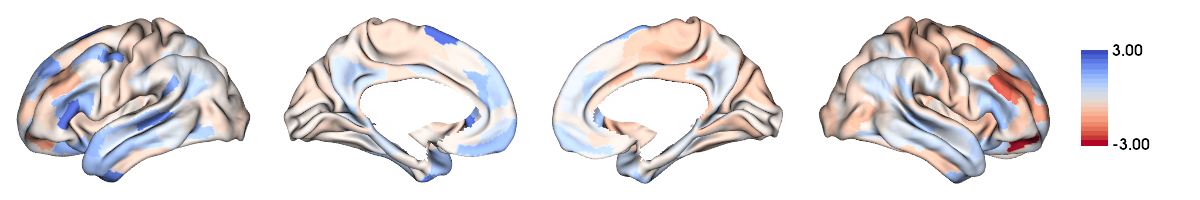

In [6]:
surf_lh, surf_rh = load_conte69()
glasser = '../data/glasser.csv'
glasser = genfromtxt(glasser)
glasser_r = glasser[32492:]
glasser_l = glasser[:32492]
glasser_r[np.where(glasser_r == 180)] = 0
glasser = np.concatenate((glasser_l,glasser_r))

mask = glasser != 0

decode = map_to_labels(cohen_lr, glasser, mask=mask)
decode[np.where(decode==0)] = np.nan
plot_hemispheres(surf_lh, surf_rh, array_name = decode, nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = coolwarm, color_bar = True, interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_5_intra_g1_cohen.svg', color_range=(-3, 3))
plot_hemispheres(surf_lh, surf_rh, array_name = decode, nan_color = (1,1,1,0.01),size = (1200, 200),
                 color_range=(-3, 3), cmap = coolwarm, color_bar = True, 
                 interactive = False, zoom = 1.5, embed_nb = True)

### visualize meta-analytical results

In [7]:
func_mmp = loadmat('../data/metaanalysis/functional_maps.mat')['funcmap']
func_mmp.shape

(24, 64984)

In [8]:
cohen_rank = ss.rankdata(cohen_lr)
for i in range(20):
  cohen_rank[np.logical_and(cohen_rank>i*18, cohen_rank<=(i+1)*18)] = i+1
cohen_64k = map_to_labels(cohen_rank, glasser, mask=mask)

In [9]:
func_bin = np.zeros((24, 20))
for i in range(24):
  for j in range(20):
    func_bin[i][j] = func_mmp[i][cohen_64k==j+1].mean()
cohen_bin = np.array([cohen_lr[cohen_rank==i+1].mean() for i in range(20)])

In [10]:
tmp_z = ss.zscore(func_bin, axis=1)
tmp=tmp_z.copy()
tmp[tmp<0.5] = np.nan
weight = tmp * cohen_bin
term_rank = np.nanmean(weight, axis=1)

In [11]:
df_intra = pd.DataFrame(tmp_z[term_rank.argsort()])

terms=np.array(['action','affective',"attention","auditory","autobiographical memory","cognitive control",
       "emotion","episodic memory","eye movement",'face','inhibition','language',
       'motor','multisensory','pain','reading','reward','semantics',
       'social cognition','verbal','visual','visual perception','visuospatial','working memory'])

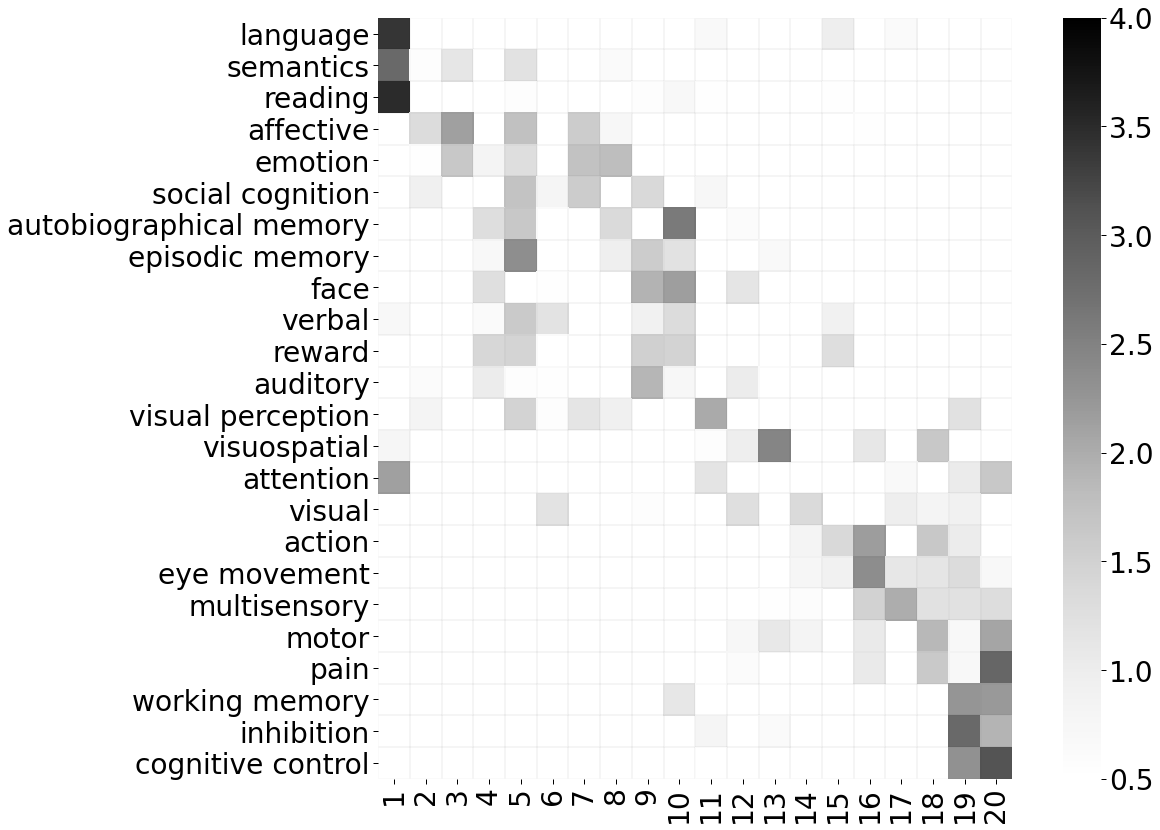

In [12]:
df_intra.index=terms[term_rank.argsort()][::-1]
df_intra.columns = range(1,21)

sns.set_context("paper", font_scale = 3.2)
f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 14), sharey = True)

sns.heatmap(df_intra, linewidths=1, square=True, linecolor = (0, 0, 0, 0.02),
            cmap='Greys', robust=False, ax = ax1,
            vmin = 0.5, vmax = 4, mask = df_intra < 0.5)
f.savefig('../figures/fig_5_intra_g1_20bins.svg')

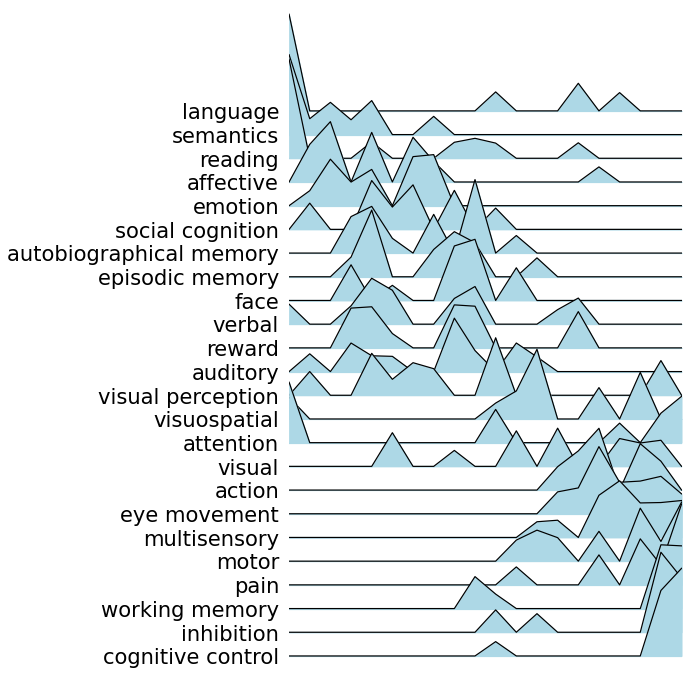

In [13]:
df_intra[df_intra<0.5] = 0

sns.set_context("paper", font_scale = 2.2)
fig,axes = jp.joyplot(df_intra.T, figsize = (10,10), x_range = range(20), 
                      color='lightblue', xlabels = False, kind = 'values')

plt.savefig('../figures/fig_5_intra_g1_wave.svg')